In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from src.train.train_bml import BetterBMLTrainer
from src.train.train_bml_alternating import AlternatingBMLTrainer
from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../models/test" 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, optimizer, val_loader, train_loader = load_dvinp(cfg, device)

    dvinp_path = f"{dir}/dvinp.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(dvinp_path):
        dvinp_state_dict = torch.load(dvinp_path, map_location=torch.device("cpu"), weights_only=True)
        dvinp.load_state_dict(dvinp_state_dict)
        print(f"loaded dvinp from {dvinp_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'), weights_only=True)
        optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 289218.52it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


In [5]:
wandb_logging = True

if wandb_logging:
    wandb.init(project="test-new")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [6]:
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]

scheduler = None #ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=500)

trainer = BetterBMLTrainer(
    device=device,
    dvinp=dvinp,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    wandb_logging=wandb_logging,
    # num_subtasks=3
)

# trainer = AlternatingBMLTrainer(
#     device=device,
#     cdvi=cdvi,
#     train_decoder_loader=train_loader[0],
#     train_cdvi_loader=train_loader[1],
#     val_loader=val_loader,
#     optimizer=optimizer,
#     wandb_logging=wandb_logging
# )

In [17]:
trainer.optimizer.param_groups[0]["lr"] = 0.2 * cfg.training.learning_rate
print(trainer.optimizer.param_groups[0]["lr"])

5.9999999999999995e-05


In [18]:
num_epochs = 100

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=cfg.training.max_clip_norm,
    alpha=cfg.training.alpha,
    validate=True
)

 56%|█████▋    | 18/32 [00:08<00:06,  2.24it/s, epoch=59, loss=42.1, lmpl=-1.86, mse=60.2]


KeyboardInterrupt: 

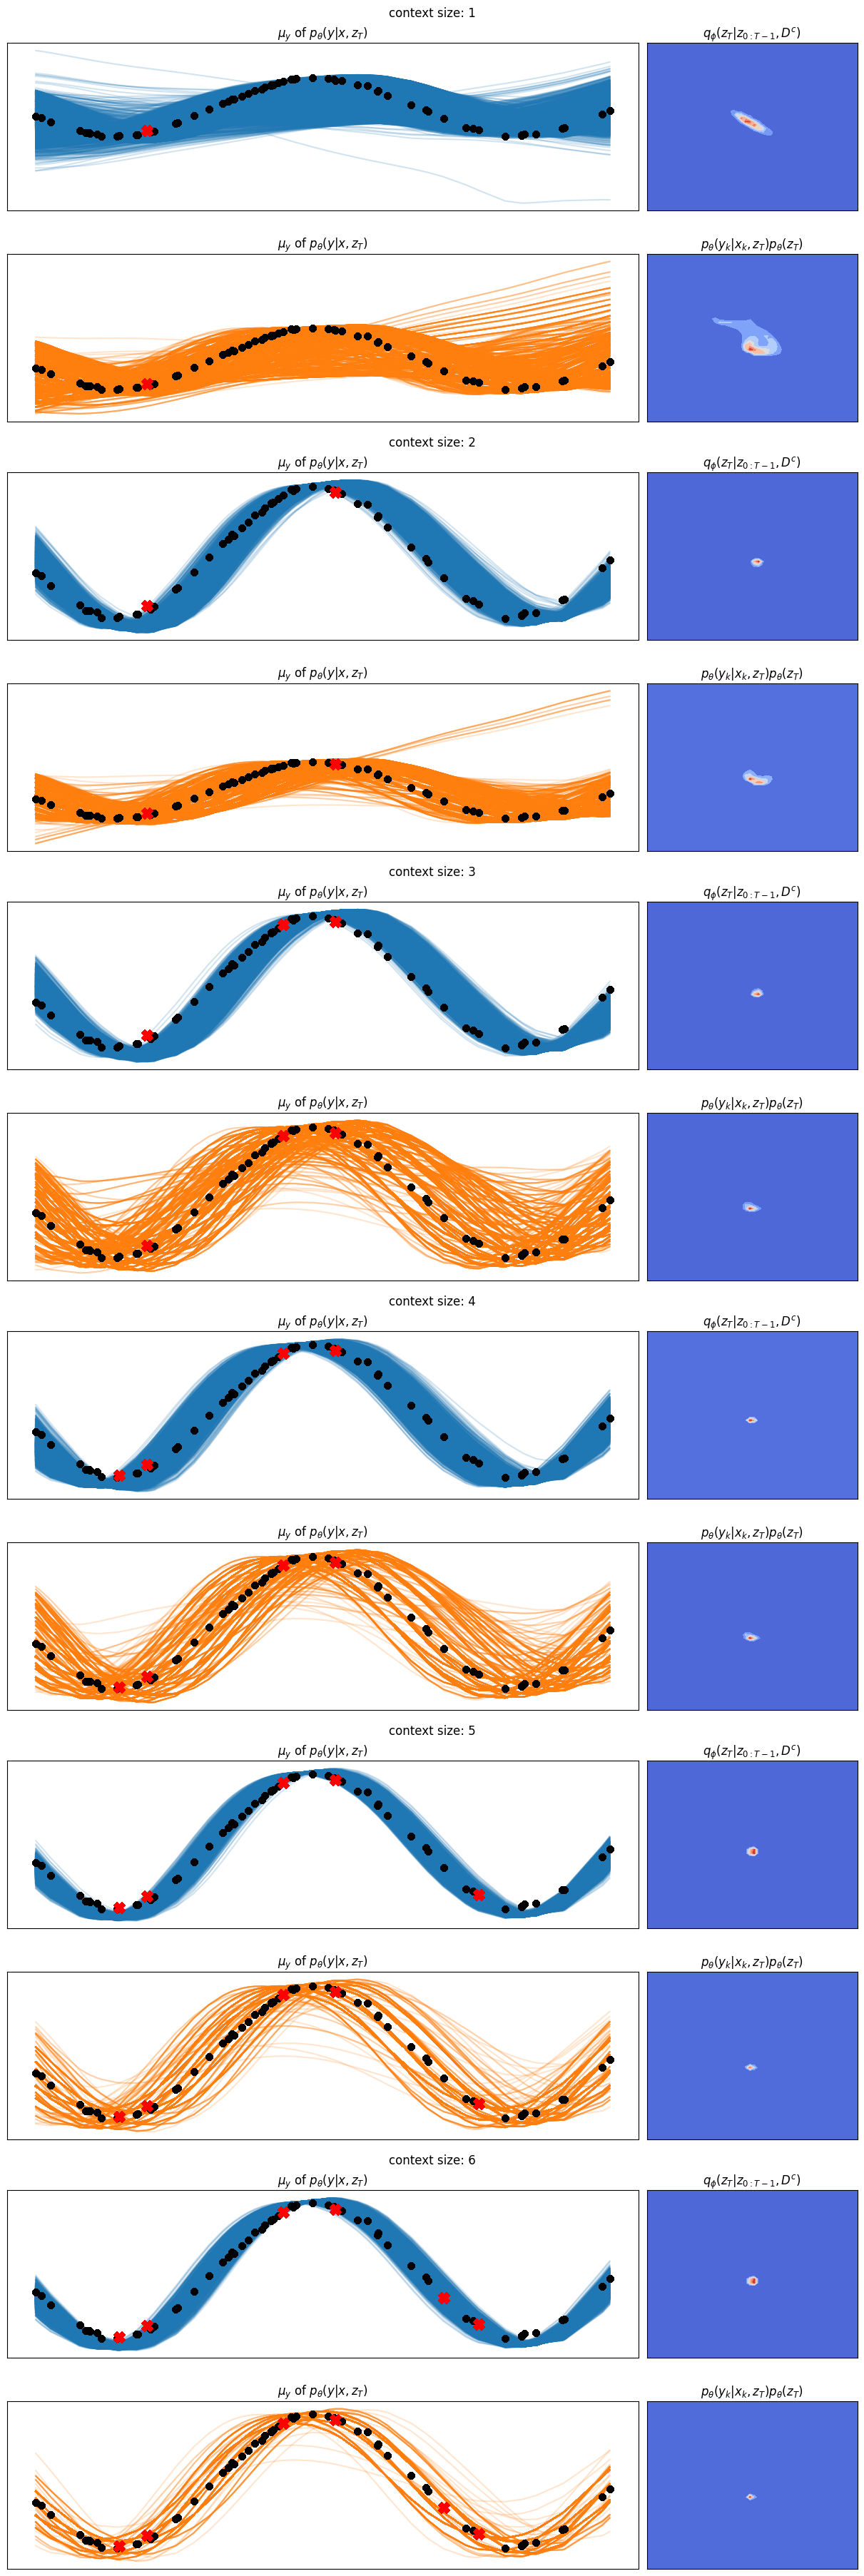

In [22]:
max_context_size = 6
num_samples = 2500 # num_cells will be root
gen_dataloader = DataLoader(val_loader.dataset, 1, True)

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [21]:
torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")